In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## v5 

In [8]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        self.norm = nn.LayerNorm((src_depth // reduce_factor, src_depth // reduce_factor, img_size, img_size))
        self.norm2 = nn.LayerNorm((src_depth, img_size, img_size))
        
        self.cor_conv = nn.Conv2d(1, 1, kernel_size=img_size, stride=img_size, padding=0)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.last_proj = nn.Sequential(nn.Conv2d(src_depth, 2*src_depth, kernel_size=1, padding=False),
                                       nn.Conv2d(2*src_depth, src_depth, kernel_size=1, padding=False))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = src_features[:, :, None, :, :] * target_features[:, None, :, :]
        cor = self.norm(cor)
        B, D1, D2, H, W = cor.size()
        cor = cor.view(B, 1, D1*H, D2*W)
        cor = self.cor_conv(cor).squeeze(1)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, k].unsqueeze(-1).unsqueeze(-1)).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x_mid = x + cor_feature
        
        x_out = self.norm2(x_mid)
        x_out = self.last_proj(x_out) + x_out
        
        return x_out

In [9]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [10]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv51_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.918509602546692 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [00:33<00:00,  6.73it/s]

- Avg.loss: 1.941 | Avg.acc: 0.245



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.833 | Avg. val_acc: 0.249
* Update optimal model
Epoch:  2


Loss=1.8296867609024048 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 1.828 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.804 | Avg. val_acc: 0.250
* Update optimal model
Epoch:  3


Loss=1.8092761039733887 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]

- Avg.loss: 1.746 | Avg.acc: 0.283



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.778 | Avg. val_acc: 0.298
* Update optimal model
Epoch:  4


Loss=1.4463204145431519 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 1.613 | Avg.acc: 0.355



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.540 | Avg. val_acc: 0.386
* Update optimal model
Epoch:  5


Loss=1.43126380443573 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]

- Avg.loss: 1.475 | Avg.acc: 0.426



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.404 | Avg. val_acc: 0.468
* Update optimal model
Epoch:  6


Loss=1.2827389240264893 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.373 | Avg.acc: 0.469



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.488
* Update optimal model
Epoch:  7


Loss=1.4397698640823364 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 1.316 | Avg.acc: 0.492



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.485 | Avg. val_acc: 0.445
Epoch:  8


Loss=1.1608532667160034 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]


- Avg.loss: 1.279 | Avg.acc: 0.508


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.504
* Update optimal model
Epoch:  9


Loss=1.77826726436615 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.246 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.303 | Avg. val_acc: 0.511
* Update optimal model
Epoch:  10


Loss=1.3454684019088745 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 1.232 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.339 | Avg. val_acc: 0.478
Epoch:  11


Loss=1.0708540678024292 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.98it/s]

- Avg.loss: 1.212 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.362 | Avg. val_acc: 0.491
Epoch:  12


Loss=1.151939034461975 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 1.186 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.295 | Avg. val_acc: 0.513
* Update optimal model
Epoch:  13


Loss=1.2345768213272095 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  7.01it/s]

- Avg.loss: 1.178 | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.233 | Avg. val_acc: 0.526
* Update optimal model
Epoch:  14


Loss=1.1873292922973633 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.167 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  15


Loss=1.0832011699676514 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 1.156 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.217 | Avg. val_acc: 0.552
Epoch:  16


Loss=1.2498220205307007 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.148 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.553
Epoch:  17


Loss=1.290157675743103 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]

- Avg.loss: 1.130 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.182 | Avg. val_acc: 0.559
* Update optimal model
Epoch:  18


Loss=1.274329423904419 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.132 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.572
* Update optimal model
Epoch:  19


Loss=1.1613761186599731 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 1.118 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.128 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  20


Loss=1.2607430219650269 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]

- Avg.loss: 1.120 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.561
Epoch:  21


Loss=1.1827349662780762 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]

- Avg.loss: 1.111 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  22


Loss=0.9854294061660767 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.107 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.578
Epoch:  23


Loss=1.4286733865737915 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 1.096 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.583
Epoch:  24


Loss=1.0605616569519043 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 1.095 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.559
Epoch:  25


Loss=1.117598056793213 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 1.088 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.576
Epoch:  26


Loss=1.0140290260314941 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.086 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133 | Avg. val_acc: 0.575
Epoch:  27


Loss=1.0334653854370117 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]


- Avg.loss: 1.086 | Avg.acc: 0.590


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.578
Epoch:  28


Loss=1.1282881498336792 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 1.081 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.571
Epoch:  29


Loss=1.0294116735458374 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 1.072 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  30


Loss=1.2109413146972656 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


- Avg.loss: 1.074 | Avg.acc: 0.594


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.596
* Update optimal model
Epoch:  31


Loss=0.9229543805122375 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 1.068 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.585
Epoch:  32


Loss=1.064010739326477 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 1.064 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.599
* Update optimal model
Epoch:  33


Loss=1.1655117273330688 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 1.066 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  34


Loss=0.8826045393943787 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

- Avg.loss: 1.061 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.595
Epoch:  35


Loss=1.1072582006454468 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 1.061 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.599
Epoch:  36


Loss=1.1150004863739014 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.061 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.581
Epoch:  37


Loss=1.0245298147201538 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 1.056 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.566
Epoch:  38


Loss=0.8918353915214539 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]

- Avg.loss: 1.056 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.579
Epoch:  39


Loss=1.3001899719238281 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.050 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.588
Epoch:  40


Loss=1.1214064359664917 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 1.050 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.596
Epoch:  41


Loss=0.9774152636528015 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 1.047 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.597
Epoch    41: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  42


Loss=0.9086210131645203 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.98it/s]

- Avg.loss: 1.000 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  43


Loss=0.9448468089103699 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 0.983 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.613
Epoch:  44


Loss=0.9110062122344971 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

- Avg.loss: 0.973 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.621
Epoch:  45


Loss=0.8194860219955444 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]

- Avg.loss: 0.978 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  46


Loss=1.042327880859375 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 0.967 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.625
Epoch:  47


Loss=0.8174758553504944 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]

- Avg.loss: 0.965 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.619
Epoch:  48


Loss=1.0933490991592407 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 0.964 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.622
Epoch:  49


Loss=1.013031005859375 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.957 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.612
Epoch:  50


Loss=0.6510957479476929 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]

- Avg.loss: 0.961 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.624
Epoch:  51


Loss=1.0620949268341064 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.956 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.627
Epoch:  52


Loss=0.9409750699996948 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.950 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.629
* Update optimal model
Epoch:  53


Loss=0.9237914085388184 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.951 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.623
Epoch:  54


Loss=0.9771798849105835 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]

- Avg.loss: 0.948 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.618
Epoch    54: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  55


Loss=0.9285629987716675 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.910 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  56


Loss=0.9798682928085327 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]

- Avg.loss: 0.894 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  57


Loss=0.869094967842102 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 0.896 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  58


Loss=0.9072083234786987 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 0.890 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.630
Epoch:  59


Loss=0.637618899345398 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.886 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.627
Epoch:  60


Loss=0.7747389078140259 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 0.879 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.631
Epoch:  61


Loss=0.9097671508789062 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 0.875 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.629
Epoch:  62


Loss=0.9324167370796204 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

- Avg.loss: 0.873 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.629
Epoch:  63


Loss=0.6719261407852173 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

- Avg.loss: 0.866 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  64


Loss=1.023708701133728 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.03it/s]

- Avg.loss: 0.871 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.634
Epoch:  65


Loss=1.0135537385940552 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.857 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.642
Epoch    65: reducing learning rate of group 0 to 5.0000e-04.
* Update optimal model
Epoch:  66


Loss=0.9449797868728638 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.836 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.640
Epoch:  67


Loss=0.8642115592956543 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 0.827 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  68


Loss=0.7871733903884888 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.821 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.642
Epoch:  69


Loss=0.7366397976875305 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.03it/s]

- Avg.loss: 0.815 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.642
Epoch:  70


Loss=0.7483339905738831 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  7.01it/s]

- Avg.loss: 0.813 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.640
Epoch:  71


Loss=0.685215950012207 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.813 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  72


Loss=0.7849963903427124 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]

- Avg.loss: 0.807 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.637
Epoch:  73


Loss=1.0862988233566284 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

- Avg.loss: 0.806 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.643
Epoch    73: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  74


Loss=0.6962941884994507 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 0.790 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.645
Epoch:  75


Loss=1.3104689121246338 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:33<00:00,  6.82it/s]

- Avg.loss: 0.785 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  76


Loss=0.9200337529182434 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 0.782 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.643
Epoch:  77


Loss=0.7503889203071594 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.771 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.649
* Update optimal model
Epoch:  78


Loss=0.6482069492340088 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.777 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.642
Epoch:  79


Loss=0.8434016704559326 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.773 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.646
Epoch:  80


Loss=0.4977898895740509 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 0.769 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  81


Loss=0.7392889857292175 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.770 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.650
Epoch    81: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  82


Loss=0.6431822180747986 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.766 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.652
Epoch:  83


Loss=0.8962940573692322 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.755 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.647
Epoch:  84


Loss=0.7809561491012573 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]

- Avg.loss: 0.760 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.650
Epoch:  85


Loss=0.6848317980766296 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.752 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.651
Epoch:  86


Loss=0.8595532178878784 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.751 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.647
Epoch:  87


Loss=1.1641002893447876 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 0.749 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.647
Epoch:  88


Loss=0.5643260478973389 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.751 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.638
Epoch:  89


Loss=0.7860864400863647 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.745 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.645
Epoch    89: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  90


Loss=0.8114521503448486 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

- Avg.loss: 0.743 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.651
Epoch:  91


Loss=0.6632131338119507 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 0.741 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.649
Epoch:  92


Loss=0.6512060165405273 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]

- Avg.loss: 0.739 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.649
Epoch:  93


Loss=0.8417052030563354 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

- Avg.loss: 0.744 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.650
Epoch:  94


Loss=0.9786263704299927 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


- Avg.loss: 0.737 | Avg.acc: 0.726


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.650
Epoch:  95


Loss=0.7660322189331055 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 0.735 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.650
Epoch:  96


Loss=0.9657835960388184 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]

- Avg.loss: 0.737 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.648
Epoch:  97


Loss=1.0966320037841797 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 0.731 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.650
Epoch    97: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  98


Loss=0.641651451587677 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

- Avg.loss: 0.729 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.649
Epoch:  99


Loss=0.7027101516723633 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 0.732 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.651
Epoch:  100


Loss=0.7320190072059631 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.738 | Avg.acc: 0.728


- Avg. val_loss: 0.993 | Avg. val_acc: 0.650
Finished Training


In [11]:
model_path = './featureactv512_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.419834852218628 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 1.635 | Avg.acc: 0.371



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.447 | Avg. val_acc: 0.447
* Update optimal model
Epoch:  2


Loss=1.4037894010543823 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 1.400 | Avg.acc: 0.465



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.340 | Avg. val_acc: 0.497
* Update optimal model
Epoch:  3


Loss=1.218477487564087 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]

- Avg.loss: 1.329 | Avg.acc: 0.494



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289 | Avg. val_acc: 0.508
* Update optimal model
Epoch:  4


Loss=1.2775338888168335 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 1.296 | Avg.acc: 0.504



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.297 | Avg. val_acc: 0.520
* Update optimal model
Epoch:  5


Loss=1.2119007110595703 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 1.272 | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.285 | Avg. val_acc: 0.518
Epoch:  6


Loss=1.0861103534698486 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 1.256 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.294 | Avg. val_acc: 0.507
Epoch:  7


Loss=1.0795996189117432 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 1.246 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.255 | Avg. val_acc: 0.524
* Update optimal model
Epoch:  8


Loss=1.3670778274536133 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]

- Avg.loss: 1.228 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.309 | Avg. val_acc: 0.499
Epoch:  9


Loss=1.4543473720550537 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]

- Avg.loss: 1.227 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.548
* Update optimal model
Epoch:  10


Loss=1.2202165126800537 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 1.208 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.208 | Avg. val_acc: 0.553
* Update optimal model
Epoch:  11


Loss=1.299680471420288 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:28<00:00,  7.83it/s]

- Avg.loss: 1.199 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.538
Epoch:  12


Loss=1.046382188796997 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 1.193 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.545
Epoch:  13


Loss=1.170137643814087 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.188 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.561
* Update optimal model
Epoch:  14


Loss=1.2776272296905518 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.188 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.545
Epoch:  15


Loss=0.9588929414749146 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.174 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.571
* Update optimal model
Epoch:  16


Loss=1.28620445728302 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 1.166 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.184 | Avg. val_acc: 0.546
Epoch:  17


Loss=1.193853497505188 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 1.165 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.549
Epoch:  18


Loss=1.104390263557434 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 1.162 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.141 | Avg. val_acc: 0.567
Epoch:  19


Loss=1.4010969400405884 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 1.154 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.560
Epoch:  20


Loss=1.5853006839752197 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]

- Avg.loss: 1.152 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.197 | Avg. val_acc: 0.543
Epoch:  21


Loss=0.7413878440856934 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]

- Avg.loss: 1.151 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.565
Epoch:  22


Loss=1.255359411239624 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]

- Avg.loss: 1.143 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.569
Epoch:  23


Loss=1.0997912883758545 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.135 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  24


Loss=1.111920714378357 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.137 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.570
Epoch:  25


Loss=0.9115106463432312 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 1.131 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  26


Loss=1.2025270462036133 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.128 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.575
Epoch:  27


Loss=1.1267828941345215 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]

- Avg.loss: 1.127 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.570
Epoch:  28


Loss=1.2426100969314575 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]

- Avg.loss: 1.125 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.558
Epoch:  29


Loss=1.3447721004486084 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:28<00:00,  7.86it/s]

- Avg.loss: 1.120 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.553
Epoch:  30


Loss=1.1068416833877563 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]

- Avg.loss: 1.117 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188 | Avg. val_acc: 0.534
Epoch:  31


Loss=1.1221054792404175 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.112 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.573
Epoch:  32


Loss=1.278540849685669 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.110 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.575
Epoch:  33


Loss=1.2130306959152222 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.110 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.177 | Avg. val_acc: 0.555
Epoch:  34


Loss=1.331642508506775 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.110 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.578
Epoch:  35


Loss=0.9867559671401978 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:28<00:00,  8.02it/s]

- Avg.loss: 1.099 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.579
Epoch:  36


Loss=1.4954099655151367 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 1.101 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.580
Epoch:  37


Loss=1.0912835597991943 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.099 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.560
Epoch:  38


Loss=1.2511653900146484 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]

- Avg.loss: 1.100 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.573
Epoch:  39


Loss=1.2828208208084106 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]

- Avg.loss: 1.100 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.581
* Update optimal model
Epoch:  40


Loss=1.1407207250595093 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.094 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.577
Epoch:  41


Loss=1.1769592761993408 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:28<00:00,  7.82it/s]

- Avg.loss: 1.088 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.578
Epoch:  42


Loss=1.0904872417449951 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.098 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.567
Epoch:  43


Loss=1.0370274782180786 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.089 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.582
Epoch    43: reducing learning rate of group 0 to 2.0000e-03.
* Update optimal model
Epoch:  44


Loss=1.276451587677002 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:31<00:00,  7.26it/s]

- Avg.loss: 1.036 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  45


Loss=0.695783793926239 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 1.021 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.604
Epoch:  46


Loss=0.9599596261978149 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 1.010 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.604
Epoch:  47


Loss=0.8395641446113586 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 1.012 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.598
Epoch:  48


Loss=1.3129464387893677 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.006 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  49


Loss=0.9415246248245239 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]

- Avg.loss: 1.003 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  50


Loss=0.8621950149536133 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:28<00:00,  7.96it/s]

- Avg.loss: 1.001 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  51


Loss=1.3188385963439941 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]

- Avg.loss: 0.999 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.604
Epoch:  52


Loss=1.1261259317398071 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 0.999 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.609
Epoch    52: reducing learning rate of group 0 to 1.0000e-03.
* Update optimal model
Epoch:  53


Loss=0.9283624887466431 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 0.960 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  54


Loss=0.952737033367157 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.950 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.610
Epoch:  55


Loss=0.9589795470237732 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.75it/s]

- Avg.loss: 0.940 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  56


Loss=0.7312204241752625 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]

- Avg.loss: 0.932 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.609
Epoch:  57


Loss=0.9870909452438354 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.934 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.618
* Update optimal model
Epoch:  58


Loss=0.9508414268493652 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.929 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  59


Loss=0.94352126121521 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]

- Avg.loss: 0.931 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  60


Loss=1.2895114421844482 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.918 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.618
Epoch:  61


Loss=0.9533920288085938 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.920 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.613
Epoch:  62


Loss=1.0772771835327148 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.907 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.617
Epoch:  63


Loss=0.9343812465667725 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:28<00:00,  8.02it/s]

- Avg.loss: 0.916 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.620
Epoch:  64


Loss=0.8972964882850647 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.908 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.615
Epoch:  65


Loss=1.2216987609863281 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 0.903 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  66


Loss=0.9615373611450195 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

- Avg.loss: 0.901 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.618
Epoch:  67


Loss=1.1161167621612549 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]

- Avg.loss: 0.901 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.620
Epoch:  68


Loss=0.7051114439964294 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.898 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.617
Epoch:  69


Loss=0.8290920853614807 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.896 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  70


Loss=1.101768136024475 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 0.892 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.621
Epoch:  71


Loss=1.0077828168869019 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.75it/s]

- Avg.loss: 0.893 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.610
Epoch:  72


Loss=0.9108237028121948 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 0.885 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.616
Epoch:  73


Loss=0.9172075390815735 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.888 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.622
Epoch:  74


Loss=0.8010077476501465 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.881 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.620
Epoch:  75


Loss=1.0123076438903809 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.883 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.621
Epoch:  76


Loss=1.0166287422180176 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.879 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.614
Epoch:  77


Loss=1.0777238607406616 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]

- Avg.loss: 0.879 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.622
Epoch    77: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  78


Loss=1.0685327053070068 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:28<00:00,  7.97it/s]

- Avg.loss: 0.853 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  79


Loss=0.7910248637199402 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.838 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  80


Loss=0.7800133228302002 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]

- Avg.loss: 0.830 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.631
Epoch:  81


Loss=1.0138181447982788 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.829 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.621
Epoch:  82


Loss=1.0234713554382324 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.829 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.630
Epoch:  83


Loss=0.7590726613998413 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]

- Avg.loss: 0.818 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.628
Epoch:  84


Loss=0.8208948373794556 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.819 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.623
Epoch:  85


Loss=1.0176668167114258 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s]

- Avg.loss: 0.817 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.624
Epoch    85: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  86


Loss=0.6530972719192505 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]

- Avg.loss: 0.799 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.631
Epoch:  87


Loss=0.9895793795585632 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.797 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.634
Epoch:  88


Loss=0.7225961685180664 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.786 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.628
Epoch:  89


Loss=0.7878645062446594 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.788 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.631
Epoch:  90


Loss=1.0044678449630737 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.781 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.627
Epoch:  91


Loss=1.1051567792892456 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.781 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.633
Epoch:  92


Loss=1.0035061836242676 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.780 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.629
Epoch:  93


Loss=0.9661521911621094 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.778 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.630
Epoch    93: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  94


Loss=0.6784688830375671 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.766 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.631
Epoch:  95


Loss=0.6547857522964478 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.763 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.627
Epoch:  96


Loss=1.0959510803222656 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]

- Avg.loss: 0.768 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.633
Epoch:  97


Loss=1.1136630773544312 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.752 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.635
Epoch:  98


Loss=0.9858719110488892 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 0.755 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.633
Epoch:  99


Loss=1.0108535289764404 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.762 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.635
Epoch:  100


Loss=0.6193839907646179 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 0.753 | Avg.acc: 0.719


- Avg. val_loss: 1.036 | Avg. val_acc: 0.629
Finished Training


([<matplotlib.lines.Line2D at 0x7fbabd6b29e8>,
 0.6522708275285595)

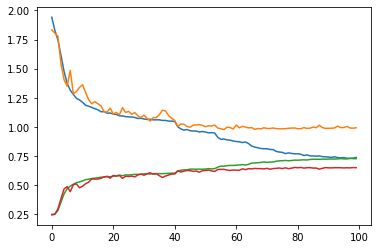

In [9]:
import pickle
pickle.dump(hist, open('featureactv51_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

([<matplotlib.lines.Line2D at 0x7f60a0ad55f8>,
 0.6352744497074394)

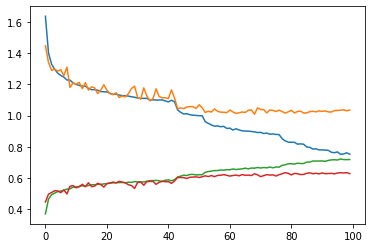

In [12]:
import pickle
pickle.dump(hist, open('featureactv512_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv51_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.952 | Avg. val_acc: 0.651


In [13]:
test_model = torch.load('featureactv512_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.986 | Avg. val_acc: 0.647
